In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Global Variables
stock_name = 'tsla' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'aapl': '12/12/1980' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'acy': '01/18/1998' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'alb': '02/21/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amat': '03/16/1980' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 11/23/21 1D, 3D, 5D ahead
               , 'amgn': '06/13/1983' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amzn': '05/12/1997' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'bby': '04/15/1985' # Updated 11/19/21 1D, 3D, 5D ahead
               #, 'bpmc': '04/27/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'crsp': '10/16/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'cost': '07/07/1986' # Updated 11/23/21 1D, 3D, 5D ahead
               , 'dis': '10/27/2014' # Updatd 11/5/21 1D, 3D, 5D ahead
               #, 'dq': '10/04/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'fslr': '11/12/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'll': '11/05/2007' # Updated 11/22/21 1D, 3D, 5D ahead
               , 'lng': '04/04/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'mdb': '10/15/2017' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'mu': '05/28/1984' # Updated 11/20/21 1D, 3D, 5D ahead
               #, 'nee': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 11/17/21 1D, 3D, 5D ahead
               #, 'pacb': '10/25/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qgen': '06/24/1996' # Updated 4/26/21 1D, 3D, 5D ahead
               #, 'run': '08/02/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'okta': '04/03/2017' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'orcl': '03/10/1986' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qcom': '12/09/1991' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'srpt': '06/02/1997' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tgt': '02/19/1973' # Updated 11/22/21 1D, 3D, 5D ahead
               #, 'tpic': '07/17/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'tsm': '10/06/1997' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 11/22/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'wmt': '11/10/2014' # Updated 11/16/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 11/21/21 1D, 3D, 5D ahead
              }

### Get Data...

In [4]:
from datetime import date, datetime
today = date.today()
print("Today's date:", today)
a.get_tables(start_dates) # commented out for 2021-12-19, data already downloaded for weekend
print('Table Updates Complete')
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time: ", current_time)

Today's date: 2022-11-01
Table Updates Complete
Current Time:  23:04:47


In [5]:
# Load RandomForextClassifier Model
# rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

In [6]:
# ROC Curve
# a.roc_plot(y_test, y_probs, stock_name, model_name)

In [7]:
# Precision Recall Curve
# a.prec_recall(y_test, y_probs, stock_name, model_name)

In [8]:
# Confusion Matrix
# a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [9]:
# Cross Validation
# a.cross_validation(rfc_model
#                    , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
#                    , stock_df['direction']
#                    , cv = 5
#                   )

### Prediction...

In [10]:
# Prediction, use last day of data
# stock_df.iloc[-1]

In [11]:
# import numpy as np
# last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
# last

In [12]:
# stock_df['adj'].describe()

In [13]:
# if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
#     print(f'Buy {stock_name} {days_ahead} day(s) ahead')
# else:
#     print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

### Strategy Returns...

In [14]:
# returns on strategy column
# stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
# stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
# stock_df.tail(5)

In [16]:
# Don't trade every day!
# import matplotlib.pyplot as plt
# test_length = len(y_test)
# (stock_df['returns'][-test_length:] + 1).cumprod().plot()
# plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
# returns_on_ones = []
# for idx in range(-test_length, 0):
#     if stock_df['prediction'][idx] == 1:
#         returns_on_ones.append(1 + stock_df['returns'][idx])

# returns = 1
# for x in returns_on_ones:
#     returns *= x
# returns

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
# test_idx = int(len(stock_df)*0.75)
# (stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

Training is done once a week on Saturday and Sunday

In [21]:
len(start_dates)

45

In [22]:
import itertools as itr
start_dates1 = dict(itr.islice(start_dates.items(), 0, 15))
start_dates1

{'a': '11/15/1999',
 'aapl': '12/12/1980',
 'adbe': '08/11/1986',
 'amat': '03/16/1980',
 'amd': '03/17/1980',
 'amgn': '06/13/1983',
 'amzn': '05/12/1997',
 'baba': '09/15/2014',
 'bac': '02/19/1973',
 'bby': '04/15/1985',
 'crm': '06/23/2004',
 'crsp': '10/16/2016',
 'cost': '07/07/1986',
 'dis': '10/27/2014',
 'esgv': '09/16/2018'}

In [23]:
start_dates2 = dict(itr.islice(start_dates.items(), 15, 30))
start_dates2

{'fslr': '11/12/2006',
 'goog': '08/16/2004',
 'ibm': '01/02/1962',
 'intc': '03/16/1980',
 'iyw': '05/15/2000',
 'll': '11/05/2007',
 'lng': '04/04/1994',
 'ma': '05/21/2006',
 'mdb': '10/15/2017',
 'msft': '03/10/1986',
 'mu': '05/28/1984',
 'nio': '09/10/2018',
 'nvda': '01/22/1999',
 'pypl': '07/05/2015',
 'qgen': '06/24/1996'}

In [24]:
start_dates3 = dict(itr.islice(start_dates.items(), 30, 45+1))
start_dates3

{'okta': '04/03/2017',
 'orcl': '03/10/1986',
 'qcom': '12/09/1991',
 'qqq': '03/08/1999',
 'srpt': '06/02/1997',
 'tgt': '02/19/1973',
 'tsla': '06/29/2010',
 'tsm': '10/06/1997',
 'v': '03/16/2008',
 'vbiv': '09/04/2002',
 'vbr': '01/26/2004',
 'viov': '09/06/2010',
 'vgt': '01/26/2004',
 'wmt': '11/10/2014',
 'xlk': '12/21/1998'}

In [25]:
# from datetime import datetime

# now = datetime.now()

# current_time = now.strftime("%H:%M:%S")
# print("Gridsearch Start Date: ", today)
# print("Current Time: ", current_time)

#Train 15 at a time!
# stocks = [x for x in start_dates1]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates2]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates3]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# # Train all, takes 15+ hours
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Train desired stocks...takes less time (4 will take 15.5 hours, each stock is roughly 2.5-4 hours to train)
# 3 will take 7.5 hours, roughly 2.5 hours per stock trained
# to train: ['cost']

# import timeit 
# stocks = ['amd'] # ['tsm', 'vbr'] # tbt as of 2021-11-20, started 01:15 PST
# days_ahead = [1, 3, 5] 
# cv = 3 # was 5 
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         %timeit a.rfc_GridSearch(X_train, y_train, stock, days, cv)

# now = datetime.now()

# current_time = now.strftime("%H:%M:%S")
# print("Gridsearch End Date: ", today)
# print("Current Time: ", current_time)

### Display All Results

**NOTE:** Returns include buying ups and selling downs

In [26]:
from datetime import date, datetime
today = date.today()
print("Today's date:", today)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time: ", current_time)

Today's date: 2022-11-01
Current Time:  23:04:47


Buy amd 1 day(s) ahead
Model Returns (x 100 for %): 5.7625
Stock Returns (x 100 for %): 5.119


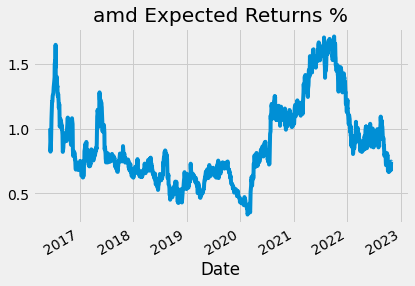

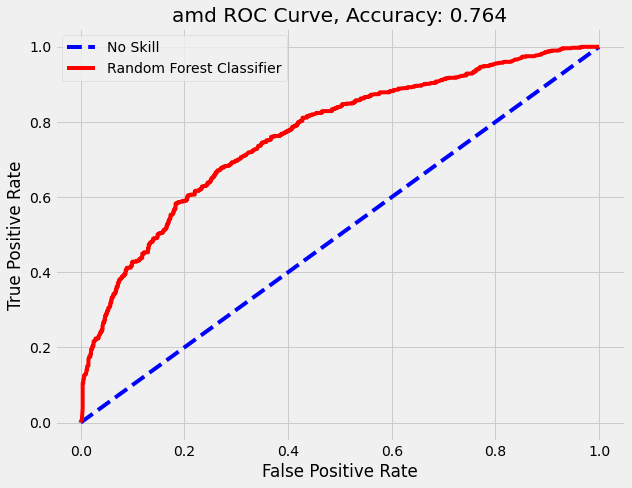

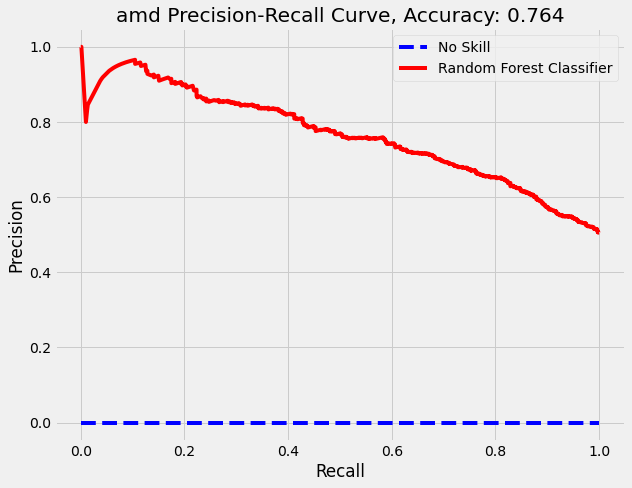

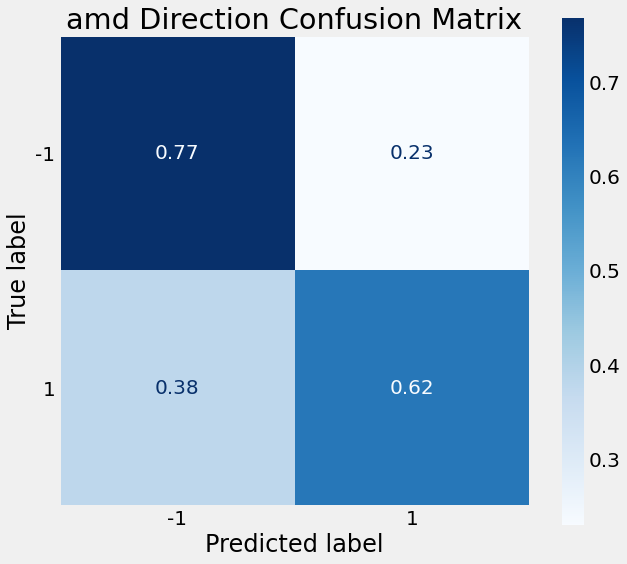

In [27]:
stock_name = 'amd'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 1
           , model_name = model_name
           , days_back = 1
          )

### Data Frame of Predictions 1 3 5 Days

**NOTE:** Returns are for buys only.

In [28]:
print("Today's date:", today)
print("Current Time =", current_time)

Today's date: 2022-11-01
Current Time = 23:04:47


In [29]:
summary_df = a.pred_summary_df(start_dates1, stocks = [x for x in start_dates1], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,a,Hold or Sell,2.0246,Hold or Sell,1.7402,Hold or Sell,1.8814,11.2903
1,aapl,Buy,3.6369,Buy,2.3873,Buy,3.2946,604.5213
2,adbe,Buy,3.7706,Buy,3.6369,Buy,3.8112,83.8173
3,amat,Buy,8.1631,Buy,7.3684,Buy,6.8985,769.3203
4,amd,Buy,6.3342,Buy,15.3710,Buy,14.0659,5.1190
5,amgn,Hold or Sell,1.8746,Hold or Sell,1.9422,Hold or Sell,1.7384,371.0828
6,amzn,Buy,1.0767,Buy,0.8460,Buy,0.8716,229.4524
7,baba,Buy,0.5408,Buy,0.9806,Buy,0.7303,-0.1624
8,bac,Buy,1.7308,Buy,1.9185,Buy,2.3209,52.5350
9,bby,Buy,0.9602,Buy,0.9360,Buy,0.8991,562.0475


In [30]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.8746, 1.8078, 1.8814, 56.4601)

In [31]:
summary_df = a.pred_summary_df(start_dates2, stocks = [x for x in start_dates2], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,fslr,Hold or Sell,1.5600,Hold or Sell,1.7946,Hold or Sell,2.0873,-0.2327
1,goog,Buy,1.9659,Buy,2.0759,Buy,2.1977,6.1060
2,ibm,Buy,1.1912,Buy,1.6729,Buy,1.3630,33.6671
3,intc,Buy,3.6552,Buy,3.3373,Buy,3.8153,103.1780
4,iyw,Buy,1.7715,Buy,2.0210,Buy,1.4631,6.3467
5,ll,Hold or Sell,0.5608,Hold or Sell,0.5341,Hold or Sell,0.6055,-0.6474
6,lng,Hold or Sell,2.3655,Hold or Sell,1.8938,Hold or Sell,1.5520,35.3520
7,ma,Hold or Sell,0.9125,Hold or Sell,1.0382,Hold or Sell,0.8012,23.2549
8,mdb,Buy,0.2684,Buy,0.3668,Buy,0.3065,1.7915
9,msft,Buy,5.2933,Buy,5.9633,Buy,5.6912,195.4707


In [32]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.56, 1.7946, 1.4631, 6.3467)

In [33]:
summary_df = a.pred_summary_df(start_dates3, stocks = [x for x in start_dates3], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,okta,Buy,0.4763,Buy,0.5420,Buy,0.3868,0.4052
1,orcl,Buy,2.4391,Buy,1.8851,Buy,2.5804,279.6469
2,qcom,Buy,2.1545,Buy,2.0099,Buy,2.9888,63.2734
3,qqq,Buy,1.9608,Buy,1.6386,Buy,1.9866,11.9750
4,srpt,Buy,0.8689,Buy,2.2866,Buy,1.9991,2.7281
5,tgt,Buy,1.4736,Buy,1.6444,Buy,1.2956,322.3099
6,tsla,Buy,0.9937,Buy,0.8609,Buy,1.1227,114.8407
7,tsm,Buy,2.8543,Buy,3.5517,Buy,3.0389,10.2383
8,v,Buy,1.0095,Buy,0.9082,Buy,1.0804,10.8059
9,vbiv,Buy,0.4148,Buy,0.5198,Buy,0.7380,-0.9735


In [34]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.4736, 1.6386, 1.5475, 10.2383)